In [6]:
# for more powerfull parameter construction
import itertools
import functools
import collections

# math library
import numpy as np

# data analysis librarz
import pandas as pd
#plotting library
import matplotlib.pyplot as plt
# display images in the notebook %matplotlib notebook makes them interactive!
%matplotlib inline

# for foldernames, timing etc
import sys
from datetime import datetime
import time

# show all resoruces available via VISA
import visa
rm = visa.ResourceManager()
print(rm.list_resources())
rm.close()

# import the actual library for the Tester
from agilentpyvisa.B1500 import *

# hide all internal logging. Set this to logging.INFO to see the commands being sent 
import logging
exception_logger.setLevel(logging.INFO)
write_logger.setLevel(logging.INFO)
query_logger.setLevel(logging.INFO)

import os
import os.path
today=datetime.today().strftime("%Y-%m-%d")
already_in = today in os.path.abspath(".")
if not already_in and not os.path.exists(today):
    os.mkdir(today)
if not already_in:
    os.chdir(today)
print(os.path.abspath("."))
SPGU_SELECTOR='SMU'

('GPIB1::17::INSTR', 'ASRL1::INSTR', 'ASRL10::INSTR')
C:\Users\krawczuk\Desktop\agilentpyvisa\2016-07-15


In [7]:
# connect to tester
b15= B1500('GPIB1::17::INSTR')
# print all connected instruments with channel numbers
for c in b15.sub_channels:
    print(c,b15.slots_installed[int(str(c)[0])].name)
b15.default_check_err=False

101 HVSPGU
102 HVSPGU
2 HRSMU
3 HRSMU
4 HRSMU
5 HRSMU
6 MFCFMU


To make creating your own measuring script easier, here are some starting helper functions and definitions.

In [8]:
# define channel numbers for use
SMU1=2 # B
SMU2=3 # C
SMU3=4 # D
SMU4=5 # E

# define setup functions with sane defaults for Memristor testing.

def get_pulse(base, peak, width,count=1, lead_part=0.8, trail_part=0.8, loadZ=1e6,gate_voltage=1.85,
              ground=SMU2,channel=101,gate=SMU3):
    """
    Defines a SPGU setup based on the given parameters
    The setup assumes we use a transistor with
    smu3->gate, 
    bottom_electrode->drain, 
    source->ground(SMU2 by default.)
    """
    mspgu=SPGU(base, peak,width, loadZ=loadZ, pulse_leading=[lead_part*width], pulse_trailing=[trail_part*width],
               condition=count )
    inp_channel=Channel(number=channel,spgu=mspgu)
    ground_channel=Channel(number=ground,dcforce=DCForce(Inputs.V,0,.1))
    gate_channel = Channel(number=gate,dcforce=DCForce(Inputs.V,gate_voltage,.1))
    spgu_test=TestSetup(channels=[ground_channel, gate_channel, inp_channel,],
                        spgu_selector_setup=[(SMU_SPGU_port.Module_1_Output_2,SMU_SPGU_state.open_relay)])
    return (spgu_test,mspgu, inp_channel, ground_channel, gate_channel)

def get_Vsweep(start, stop, steps, compliance=300e-6,
               measure_range=MeasureRanges_I.full_auto,gate_voltage=1.85, ground=SMU2):
    """
    Defines a Sweep setup based on the given parameters
    The setup assumes we use a transistor with
    smu3->gate, 
    bottom_electrode->drain, 
    source->ground(SMU2 by default. We also measure here.SMU1 if you do not want to use the transistor for current limiting.)
    """
    swep_smu=b15.slots_installed[b15._B1500__channel_to_slot(3)]
    in_range=swep_smu.get_mincover_V(start,stop)
    
    sweep_measure=MeasureStaircaseSweep(Targets.I,range=measure_range, side=MeasureSides.current_side)
    
    sweep = StaircaseSweep(Inputs.V,InputRanges_V.full_auto,start,stop,steps,compliance, auto_abort=AutoAbort.disabled)
    
    inp_channel=Channel(number=SMU4,staircase_sweep=sweep, measurement=sweep_measure)
    
    ground_channel=Channel(number=ground,
                           dcforce=DCForce(Inputs.V,0,compliance),
                          )
    
    gate_channel = Channel(number=SMU3,dcforce=DCForce(Inputs.V,gate_voltage,.1),
                          )
    
    sweep_test=TestSetup(channels=[gate_channel,ground_channel,inp_channel],
                         spgu_selector_setup=[(SMU_SPGU_port.Module_1_Output_2,SMU_SPGU_state.open_relay)],
                        output_mode=OutputMode.with_primarysource,
                        format=Format.ascii13_with_header_crl, filter=Filter.enabled)
    return (sweep_test,sweep, inp_channel, ground_channel, gate_channel)


# some very basic analysis functions

def get_R(d, current_column='EI', voltage_column='EV'):
    """
    Takes in padnas.DataFrame and optional column labels, returns average Resistance
    """
    R = d[voltage_column]/d[current_column]
    # remove all infinite resistances
    R=R.replace([np.inf, -np.inf], np.nan).dropna()
    return R.abs().mean()



def plot_output(out, t='line',up='b',down='r', voltage_column='EV', current_column='EI',fig=None,ax1=None,ax2=None):
    """ Show bat plot of voltage sweep, with different colours for up and down sweep"""
    if not (fig and ax1 and ax2):
        fig, ax1=plt.subplots()
        ax2=ax1.twinx()
    lout = out[[voltage_column, current_column]]
    lout=lout[lout.applymap(lambda x: not np.isnan(x)).all(axis=1)] # remove NaN values
    y=lout[current_column].abs()*1e6 # scale up current from microns
    x=np.array(lout[voltage_column]) 
    half = lout[voltage_column].abs().idxmax() # find peak of sweep for up/down plot
    if t=='line':
        ax1.plot(x[:half],y[:half], color=up,marker='o')
        ax1.plot(x[half:],y[half:], color=down,marker='o')
    elif t=='scatter':
        ax1.scatter(x[:half],y[:half], color=up,marker='o')
        ax1.scatter(x[half:],y[half:], color=down,marker='o')
    if 'cumulative_energy' in out.columns:
        if t=='line':
            ax2.plot(x[:half],out['cumulative_energy'][:half]*1000,color='g',marker='x')
            ax2.plot(x[half:],out['cumulative_energy'][half:]*1000,color='g',marker='x')
        elif t=='scatter':
            ax2.scatter(x[:half],out['cumulative_energy'][:half]*1000,color='g',marker='x')
            ax2.scatter(x[half:],out['cumulative_energy'][half:]*1000,color='g',marker='x')
        ax2.set_ylabel("Total Energy consumed in mW")
        
    ax1.set_ylabel('Ground current in uA')
    plt.xlabel('Voltage forced in V')
    plt.autoscale()
    
# test functions
assert(get_pulse(0,1,0.5))  # base 0, peak 1V, width 0.5 s
assert(get_Vsweep(0,1,50))  # start 0, stop 1, 50 steps

With the setup functions, we define some basic procedures, which make up the vocabulary for our test

In [9]:
# base abstract procedures
def add_energy(datum):
    datum['cumulative_energy']=(datum['ET'].diff().fillna(0)*datum['EI']*datum['EV']).cumsum()
    return datum
def sweep(stop, steps, compliance=300e-6,start=0,mrange=MeasureRanges_I.full_auto,
          gate=1.85, plot=True, up='b',down='r', ground=SMU2, stats=True):
    """ Create and immediately perform a sweep, optionally plot the data and/or show statistics"""
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    global SPGU_SELECTOR
    SPGU_SELECTOR='SMU'
    set_setup,set, _ ,ground_channel,gate_channel=get_Vsweep(start=start,stop=stop,steps=steps, compliance=compliance,
                                                                     measure_range=mrange,gate_voltage=gate, ground=ground)
    ret,out =b15.run_test(set_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    out=add_energy(out)
    if plot:
        plot_output(out, up=up,down=down)
    if stats:
        print(out.describe())
    return out

def pulse(p_v, width, slope, gate=SMU3, gate_voltage=1.85,ground=SMU2,loadZ=1e6,count=1):
    reset_pulse_setup, reset_pulse,_,_,_= get_pulse(0,p_v,width,
                                                    lead_part=slope,trail_part=slope,gate=gate,gate_voltage=gate_voltage,
                                                    ground=ground,loadZ=loadZ,count=count
                                                   )
    global SPGU_SELECTOR
    SPGU_SELECTOR='SPGU'
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SPGU)
    b15.run_test(reset_pulse_setup,force_wait=True,force_new_setup=True)

    
    
# some more concrete cases, with the defaults we use initially
def read(start=200e-6,stop=250e-6, steps=51,mrange=MeasureRanges_I.uA100_limited,
         gate=1.85, plot=True, print_R=True, stats=True):
    """
    A quick sweep to estimate the current Resistance of the DUT
    """
    out = sweep(start=start,stop=stop,steps=steps,mrange=mrange,gate=gate,plot=plot,stats=stats)
    out.to_csv("{}_read.csv".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
    return out

def checkR(start=200e-6,stop=350e-6, steps=51,mrange=MeasureRanges_I.uA100_limited,  gate=1.85):
    """
    Perform a read and calculate the mean, throw everything else away
    """
    out= read(start=start,stop=stop, steps=steps,mrange=mrange,gate=gate, plot=False,stats=False)
    R= get_R(out)
    return R


def form(forming_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85):
    """
    Initial form sweep for the DUT
    """
    return sweep(forming_v, steps, compliance,mrange=mrange, gate=gate, plot=True, up='c', down='m')
    
    
def set_sweep(set_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85, plot=True):
    """
    DC Set, with SMU2 as ground -> transistor limits current in LRS after set
    """
    return sweep(set_v, steps, compliance,mrange=mrange, gate=gate, plot=plot, up='c', down='m')
    
def reset_sweep(reset_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85, plot=True):
    """
    DC reset, with SMU1 as ground -> no transistor limiting
    """
    return sweep(reset_v, steps, compliance,mrange=mrange, gate=gate, plot=plot, ground=SMU1)

# uncomment to test the functions, but beware, they do use the tester
#assert(read(stats=False,plot=False) is not None)
#assert(form(0,10,0.1) is not None)
#assert(set_sweep(0,10,0.1) is not None)
#assert(reset_sweep(0,10,0.1) is not None)

We can then also build more complex testing procedures from these building blocks

In [10]:
cycle_members=['resetV','setV','reset_width','set_width','slope','resetGateV','setGateV','loadZreset','loadZset']
class cycle_setup(collections.namedtuple('_cycle_setup',cycle_members)):
    def __new__(cls,
                 resetV=-0.5,setV=0.8,
                 reset_width=1e-3,set_width=1e-3,
                 slope=0.8,
                 resetGateV=1.9,setGateV=1.9,
                 loadZreset=1e6,loadZset=1e6):
        return super().__new__(cls,resetV,setV,reset_width,set_width,slope,resetGateV,setGateV,loadZreset,loadZset)

def pulse_cycle(setup, checkr=True):
    """
    Perform a reset/set cycle using the spgu, checking the change of R with a read pre reset, post reset and post set
    """
    if checkr:
        pre_reset =checkR()
    pulse(setup.resetV, setup.reset_width, setup.slope,ground=SMU1,gate_voltage=setup.resetGateV,loadZ=setup.loadZreset)
    if checkr:
        pre_set = checkR()
    pulse(setup.setV, setup.set_width,setup.slope,gate_voltage=setup.setGateV,loadZ=setup.loadZset)
    if checkr:
        post_set=checkR()
    if checkr:
        return (pre_reset, pre_set, post_set)
    else:
        return (None,None,None)

def pulse_iter(test_setup, max_iter=100, abort_break=True, flush_setup=None, checkr=True):
    """
    An iterator which performs max_iter pulse cycles,
    or optionally until there is no order of magnitude change between set& reset
    """
    i=0
    while True:
        #if i%100 == 0:
        #    print('Iteration ',i)
        pR,pS,poS = pulse_cycle(test_setup,checkr)
        yield (pR,pS,poS)
        if flush_setup:
            pR,pS,poS = pulse_cycle(flush_setup, checkr)
            yield (pR,pS,poS)
            
        if (abort_break  and np.log10(poR/poS) < 1) or i>=max_iter:
            
            break
        else:
            i+=1
    raise StopIteration
    

def test_pulse(test_setup,iters,flush_setup=None,plot=True, abort_break=True,checkr=True):
    """
    Build a pulse_iter from given parameters and construct a dataFrame from it
    """
    c3=pd.DataFrame(np.fromiter(pulse_iter(test_setup=test_setup,
                                           abort_break=abort_break,
                                           flush_setup=flush_setup,
                                          max_iter=iters, checkr=checkr),
                      dtype=[('preReset',np.float),('preSet',np.float),('postSet',np.float)]))
    print(c3.describe())
    if checkr:
        if plot:
            c3.plot()
        return c3
    else:
        return None

And even more complex tests with automated logging, estimation when we are done and some basic SI unit handling

# Sample tests

Below is how I used the setup above when testing, together with the results

                 EI            ET          EV  cumulative_energy
count  2.000000e+02    200.000000  200.000000         200.000000
mean   1.503169e-04  68219.291050    1.500000           0.000121
std    4.576286e-05      0.275408    0.876928           0.000089
min    9.500000e-09  68218.780000    0.000000           0.000000
25%    1.622750e-04  68219.060000    0.749937           0.000030
50%    1.723000e-04  68219.290000    1.500000           0.000120
75%    1.737375e-04  68219.522500    2.250063           0.000212
max    1.750500e-04  68219.770000    3.000000           0.000240


4123.348692046334

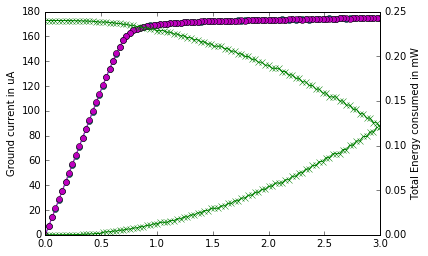

In [87]:
form_sweep= plt.figure(figsize=[10,5])
f=form(3,100,10e-3, mrange=MeasureRanges_I.uA10_limited,gate=1.9)
f=add_energy(f)
f.to_csv("{}_form_3V.csv".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
plt.autoscale()
checkR()

31778.409090909096
                 EI            ET          EV  cumulative_energy
count  2.000000e+02    200.000000  200.000000         200.000000
mean  -1.521310e-05  67571.562550   -0.750000           0.000008
std    1.353450e-05      0.303423    0.438458           0.000007
min   -7.707500e-05  67571.010000   -1.500000          -0.000000
25%   -2.145375e-05  67571.310000   -1.125000           0.000001
50%   -1.249500e-05  67571.575000   -0.750000           0.000009
75%   -6.313875e-06  67571.810000   -0.375000           0.000015
max    1.000000e-09  67572.080000    0.000000           0.000016
38021.08433734939


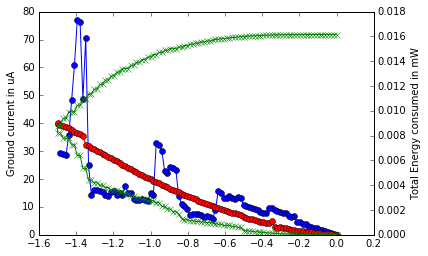

In [84]:
print(checkR())
reset_sweep(-1.5,100,5e-3, mrange=MeasureRanges_I.uA10_limited,gate=SMU3,plot=True)
print(checkR())

Reset with Peak -1.5V, 100 steps, gate 1.9V
               EI            ET          EV  cumulative_energy
count  200.000000    200.000000  200.000000         200.000000
mean    -0.000064  68223.094050   -0.750000           0.000035
std      0.000076      0.287616    0.438458           0.000021
min     -0.000230  68222.570000   -1.500000          -0.000000
25%     -0.000121  68222.857500   -1.125000           0.000013
50%     -0.000023  68223.095000   -0.750000           0.000048
75%     -0.000007  68223.332500   -0.375000           0.000052
max      0.000000  68223.600000    0.000000           0.000053
HRS 33068.273092369476
Set with Peak 1.5V, 100 steps, gate 1.9V
                 EI           ET          EV  cumulative_energy
count  2.000000e+02    200.00000  200.000000         200.000000
mean   9.353574e-05  68227.16030    0.750000           0.000044
std    6.996351e-05      0.28656    0.438458           0.000037
min   -3.500000e-09  68226.64000    0.000000          -0.000000
25%  

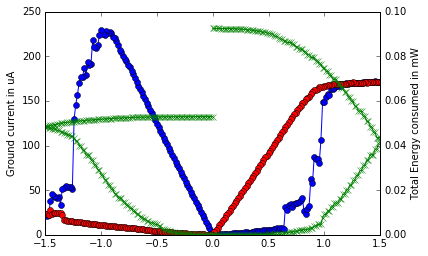

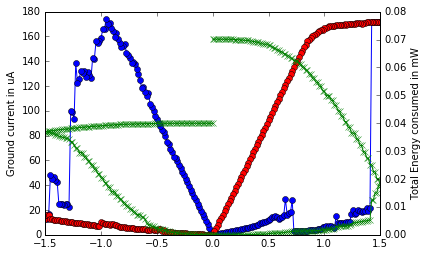

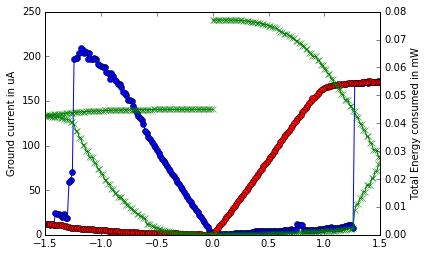

In [88]:
perc = np.ones(3)
iters= len(perc) 
pinches=[]
sleep_between=1
for i in range(iters):
    fig,ax1 = plt.subplots()
    ax2=ax1.twinx()
    #plt.suptitle("Reset gate 1.9V, Set gate {}V".format(perc[i]*1.9))
    plt.hold(True)
    rgate = 1.9
    rpeak=-1.5
    rsteps=100
    print('Reset with Peak {}V, {} steps, gate {}V'.format(rpeak, rsteps, rgate))
    rt=reset_sweep(rpeak, rsteps,5e-3, mrange=MeasureRanges_I.uA10_limited,gate=rgate,plot=False)
    rt=add_energy(rt)
    rt.to_csv("{}_reset_gate{}_-1_5V.csv".format(
            datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),rgate)
             )
    plot_output(rt,fig=fig,ax1=ax1,ax2=ax2)
    
    print('HRS',checkR())
    time.sleep(sleep_between)
    speak= 1.5
    ssteps= 100
    sgate= 1.9 * perc[i]
    print('Set with Peak {}V, {} steps, gate {}V'.format(speak, ssteps, sgate))
    s=set_sweep(speak,ssteps,10e-3, mrange=MeasureRanges_I.uA10_limited,gate=sgate,plot=False)
    s=add_energy(s)
    s.to_csv("{}_set_gate{}_1V.csv".format(
            datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),sgate)
            )
    plot_output(s,fig=fig,ax1=ax1,ax2=ax2)
    
    print('LRS',checkR())
    time.sleep(sleep_between)
    #plt.yscale("log")
    pinches.append((rt,s,rgate,sgate))

frames=[]
for rt,s,rgate,sgate in pinches:
    rt['gateV']=[rgate]*len(rt.index)
    rt['type']='reset'
    s['gateV']=[sgate]*len(s.index)
    s['type']='set'
    frames.append(rt)
    frames.append(s)
frames = pd.concat(frames)
frames.to_csv('{}_pinchrun.csv'.format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))

In [58]:
pulse_members=['voltage','width','slope','gate','gateVoltage','count']
class pattern_pulse(collections.namedtuple('_pulse_setup',pulse_members)):
    def __new__(cls,voltage,width,slope,gate,gateVoltage,count=1):
        return super().__new__(cls, voltage, width, slope, gate,gateVoltage,count)

checkr_members=['after']
class pattern_checkR(collections.namedtuple('_checkR', checkr_members)):
    def __new__(cls,after=None):
        return super().__new__(cls,after)

def handle_pattern(p,print_check=False):
    global SPGU_SELECTOR
    if isinstance(p,pattern_pulse):
        if not SPGU_SELECTOR=='SPGU':
            SPGU_SELECTOR='SPGU'
            b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SPGU)
        pulse(p.voltage, p.width, slope=p.slope, gate=p.gate, gate_voltage=p.gateVoltage,loadZ=1e6,count=p.count )
        return p
    elif isinstance(p, pattern_checkR):
        R=checkR()
        if print_check:
            print(R)
        return R

def consume_patterns(job_patterns,time_est_every=100,print_check=False):
    resp=[]
    est=None
    beginning=time.time()
    start=time.time()
    end=len(job_patterns)
    for i,p in enumerate(job_patterns):
        if i and i%time_est_every==0:
            time_per_run = (time.time()-start)/time_est_every
            print('estimated end',
                          time.strftime('%H:%M:%S',
                                        time.localtime(time.time()+time_per_run*(end-i))
                                        ),
                          " time per measurement:",
                          time_per_run,
                          "seconds"
                         )
            start=time.time()
        try:
            resp.append( (i,handle_pattern(p,print_check)))
        except BaseException as e:
            print(e)
            resp.append((i,e))
        finally:
            pass
    return resp

def get_pyramid_pattern(baseVoltages=(-3.2,2.4), baseGateVoltages=(1.9,1.9),
                         voltagePercentages=[(1,1)],
                        gatePercentages=[(1,1)],widths=[(1000e-6,1000e-6)], checkR_every=1,
                       slopes=[(0.2,0.2)]):
    assert(len(voltagePercentages)==len(gatePercentages)==len(widths)==len(slopes))
    patterns=[]
    i=0
    while True:
        if i>=len(voltagePercentages):
            break
        #reset pattern
        patterns.append(pattern_pulse(voltage=baseVoltages[0]*voltagePercentages[i][0],
                                      width=widths[i][0],
                                      slope=slopes[i][0],
                                      gate=SMU3,
                                     gateVoltage=baseGateVoltages[0]*gatePercentages[i][0])
                       )
        # set pattern
        patterns.append(pattern_pulse(voltage=baseVoltages[1]*voltagePercentages[i][1],
                                      width=widths[i][1],
                                      slope=slopes[i][1],
                                      gate=SMU3,
                                     gateVoltage=baseGateVoltages[1]*gatePercentages[i][1])
                       )
        i+=1
    rev =[]
    i=len(patterns)
    while i>0:
        rev.append(patterns[i-2])
        rev.append(patterns[i-1])
        i-=2
    return insert_read_every(patterns+rev,checkR_every)
def insert_read_every(pattern,every=1):
    new_pattern=[]
    i=0
    while i<len(pattern):
        if (i%every)==0 or (i%every)==1:
            new_pattern.append(pattern_checkR())
        new_pattern.append(pattern[i])
        i+=1
    new_pattern.append(pattern_checkR())
    return new_pattern

def get_random_pattern(pattern_length,
                       reset_pulse_range=(0,-3.2),
                       set_pulse_range=(0,2.4),
                       reset_gate_range=(1.9,1.9),
                       set_gate_range=(1.9,1.9),
                       width_range=(500e-6,1000e-6),
                       slope_range=(0.2,0.2)
                      ):
    dist=np.random.uniform
    
    if pattern_length%2!=0:
        print("Shortening to nearest multiple of 2, only do reset-set pairs")
    pattern=[]
    for i in range(pattern_length//2):
        pattern.append(pattern_pulse(voltage=dist(*reset_pulse_range),
                                      width=dist(*width_range),
                                      slope=dist(*slope_range),
                                      gate=SMU3,
                                     gateVoltage=dist(*reset_gate_range)
                                    )
                      )
        pattern.append(pattern_pulse(voltage=dist(*set_pulse_range),
                                      width=dist(*width_range),
                                      slope=dist(*slope_range),
                                      gate=SMU3,
                                     gateVoltage=dist(*set_gate_range)
                                    )
                      )
    return pattern

def get_series(numpulses,peak,width=1000e-6,slope=0.2,gateV=1.9,count=1):
    return [pattern_pulse(voltage=peak,width=width,slope=slope,gateVoltage=gateV,gate=SMU3,count=count) for _ in range(numpulses)]
get_series(5,-1.5)

def parse_job_results(results):
    res=[]
    proto = {'Resistance':None,'Voltage':None,'gateVoltage':None,'Type':None,'width':None,'slope':None}
    for i,r in results:
        p = proto.copy()
        if isinstance(r,float):
            post=''
            if len(res)>0 and res[-1].get('Type'):
                post=' after '+res[-1]['Type']
            p['Resistance']=r
            p['Type']='Check'+post
        elif isinstance(r,pattern_pulse):
            p['Voltage']=r.voltage
            p['gateVoltage']=r.gateVoltage
            p['width']=r.width
            p['slope']=r.slope
            if r.voltage > 0:
                p['Type']='Set'
            else:
                p['Type']='Reset'
        res.append(p)
    return pd.DataFrame(res)
def plot_pattern_results(rdf,figsize=[10,10],fill=False):
    fig, ax1 = plt.subplots(figsize=figsize)
    ax2=ax1.twinx()
    rsr=rdf[rdf['Type']=='Check after Reset']['Resistance']
    rss=rdf[rdf['Type']=='Check after Set']['Resistance']
    
    if fill:
        ax2.fill(rss.index,rss.values,'y')
        ax2.fill(rsr.index,rsr.values,'g')
    
    ax2.scatter(rsr.index,rsr.values,c='g',marker='o',label='Resistance after Reset', zorder=10)
    ax2.scatter(rss.index,rss.values,c='y',marker='o',label='Resistance after Set', zorder=10)
    rtdf = rdf[rdf['Type']=='Reset']
    sdf = rdf[rdf['Type']=='Set']
    for c,df,run in zip(['r','b'],[rtdf,sdf],['Reset','Set']):
        v=df['Voltage'].dropna()
        ax1.scatter(v.index,v.values,c=c,marker='+',label='Voltage '+run)
        gv=df['gateVoltage'].dropna()
        ax1.scatter(gv.index,gv.values,c=c,marker='x',label='gateVoltage '+run)
    ax1.legend(loc=2)
    ax2.legend(loc=1)

401  patterns
7566.009698362642
14786.011904761905
7612.142623172034
16423.503064592176
5852.41454607804
estimated end 12:49:19  time per measurement: 0.5687000036239624 seconds
7068.382869853459
6532.294774941835
8865.546218487396
7468.029927588749
8026.302945420594
estimated end 12:49:19  time per measurement: 0.5686000108718872 seconds
6602.137105813577
7387.23599385364
6315.29173440938
11845.473833097592
6680.39068774363
estimated end 12:49:18  time per measurement: 0.5656999826431275 seconds
8568.098704128113
6059.6753464400535
23107.27086533538
6927.3141074611685
9670.206971677559
estimated end 12:49:20  time per measurement: 0.5713999986648559 seconds
5738.548216489393
6192.827597239363
6292.278527572648
7086.057733116559
6231.808088425734
estimated end 12:49:18  time per measurement: 0.5671000003814697 seconds
38690.47619047619
5714.35809000688
6881.720403779227
7005.995502319035
33005.95238095239
estimated end 12:49:18  time per measurement: 0.565499997138977 seconds
6013.8737

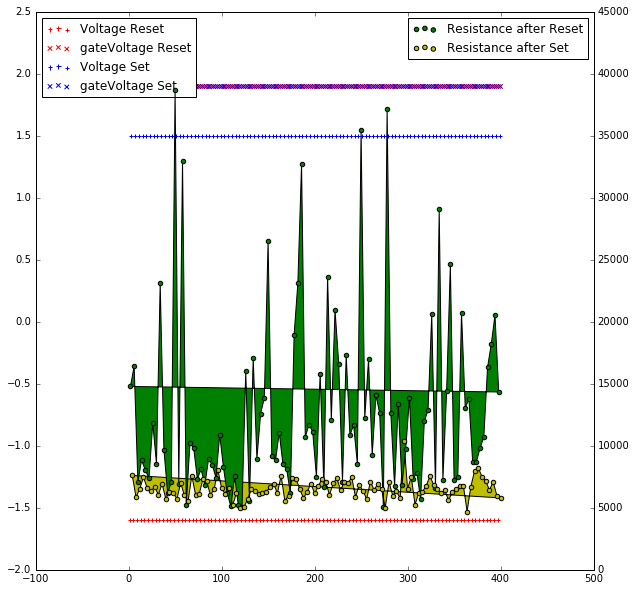

In [94]:
#baseV = ( i*1 for i in (-2800,1000))  #mV

baseV =  (-1.6,1.5)  #mV

basegate=1.9 #mV
basewidth=1000e-6  #us

r,s=baseV


gate_perc=list(zip(np.ones(50),np.ones(50)))

vP=len(gate_perc)*[(1,1)]
widths=[(1000e-6,500e-6)]*len(gate_perc)
slopes =len(gate_perc)* [(0.2,0.2)]


job_pattern=get_pyramid_pattern(baseGateVoltages=(basegate,basegate),baseVoltages=baseV,
                                gatePercentages=gate_perc,voltagePercentages=vP,slopes=slopes,widths=widths,
                               checkR_every=1 )

print(len(job_pattern)," patterns")









if 1:
    job_done=consume_patterns(job_pattern,10,print_check=True)
    rdf=parse_job_results(job_done)
    rdf.to_csv("{}_pyramid.csv".format( datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
    print(rdf)
    plot_pattern_results(rdf,fill=True)

In [177]:
def reset_pulse_energy_estimate(peak,width,slope,lrs_res=2e3,hrs_res=15e3):
    lrs_energy=(0.5*slope+(0.5-slope))*width*peak*peak/lrs_res
    hrs_energy=(0.5*slope+(0.5-slope))*width*peak*peak/hrs_res
    return lrs_energy+hrs_energy
reset_pulse_energy_estimate(-1.5,1,0.2)

0.00051

In [183]:
import scipy.stats as stat
from sklearn.naive_bayes import GaussianNB

stat.normaltest(rdf.iloc[rdf[rdf['Type']=='Set'].index[0:-1]+1]['Resistance'].values)

NormaltestResult(statistic=0.42627940789849994, pvalue=0.80804324249861126)

In [ ]:
res_state=GaussianNB()
#lrsmean=1820, std=22
#res_state.fit(data,labels)
def is_lrs(datum):
    sp.s
def is_hrs(datum):
    

In [243]:
search=[]

1414.15996622
1417.27248566
1464.73235268
1422.30407115
1473.41126125


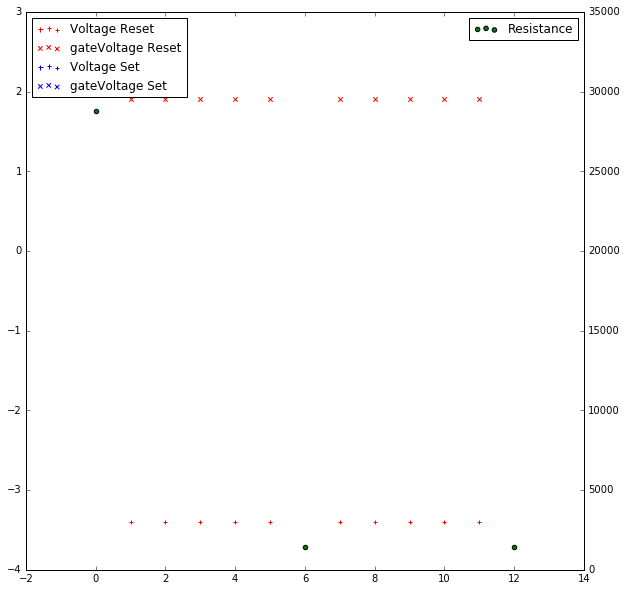

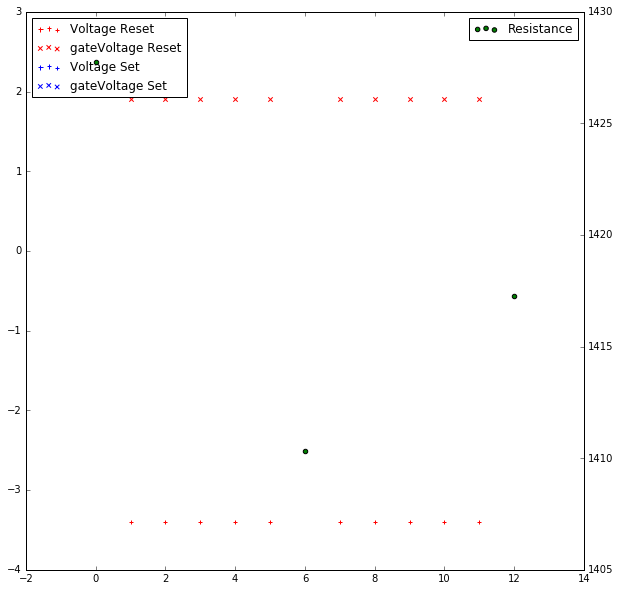

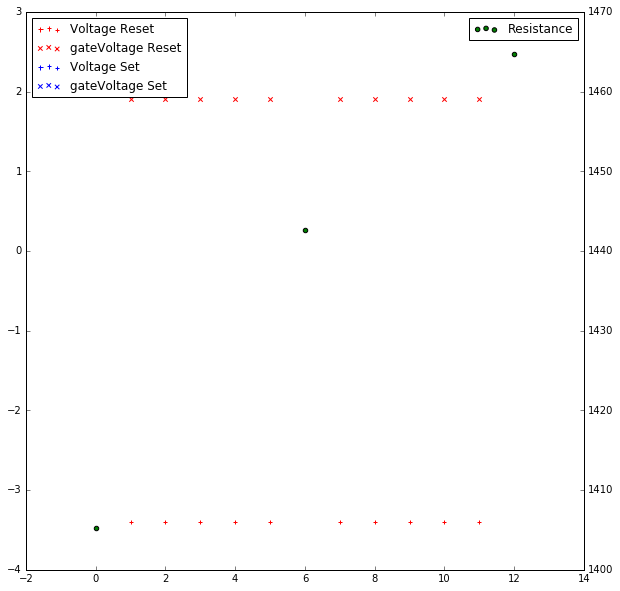

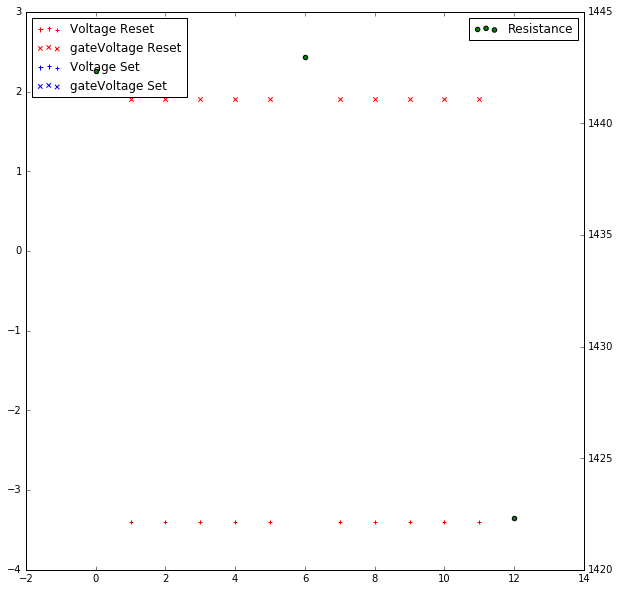

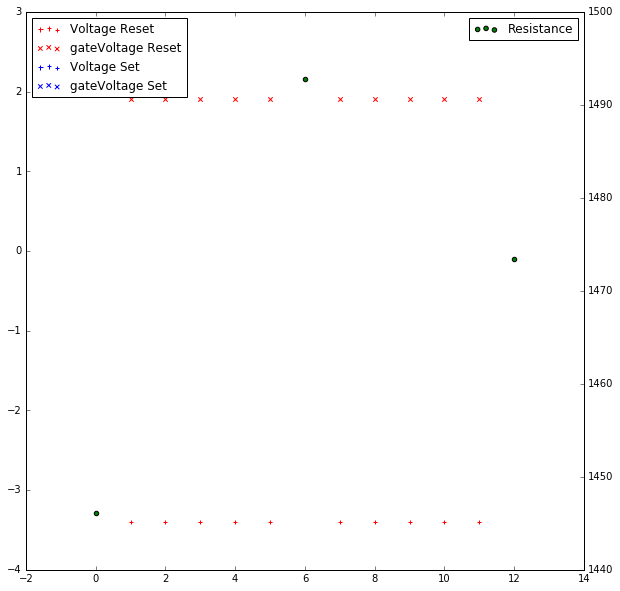

In [279]:

for i in range(5):
    find_hrs=get_series(10,-3.4,width=500e-6,slope=.2,count=100)
    find_hrs=insert_read_every(find_hrs,5)
    find_out=consume_patterns(find_hrs)
    fhr =parse_job_results(find_out)
    search.append(fhr)
    plot_pattern_results(fhr)
    print(fhr.iloc[-1]['Resistance'])
    if fhr.iloc[-1]['Resistance']>12e3:
        break

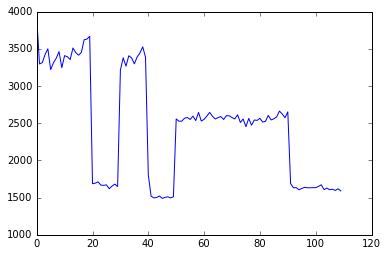

In [263]:
res_found=pd.concat(search)['Resistance'].dropna()
plt.plot(range(len(res_found)),res_found.values)

In [252]:
get_series(5,-1,width=1000e-6)

[pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9),
 pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9),
 pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9),
 pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9),
 pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9)]